In [ ]:
!pip install pykalman
!pip install ffn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ffn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import yfinance as yf
import datetime

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE','MSFT']

df = yf.download(tickers, start, end)['Close']
df

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2013-01-02,38.340000,27.620001
2013-01-03,37.750000,27.250000
2013-01-04,38.130001,26.740000
2013-01-07,37.939999,26.690001
2013-01-08,38.139999,26.549999
...,...,...
2018-12-24,205.160004,94.129997
2018-12-26,222.949997,100.559998
2018-12-27,225.139999,101.180000


In [ ]:
def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means


#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means


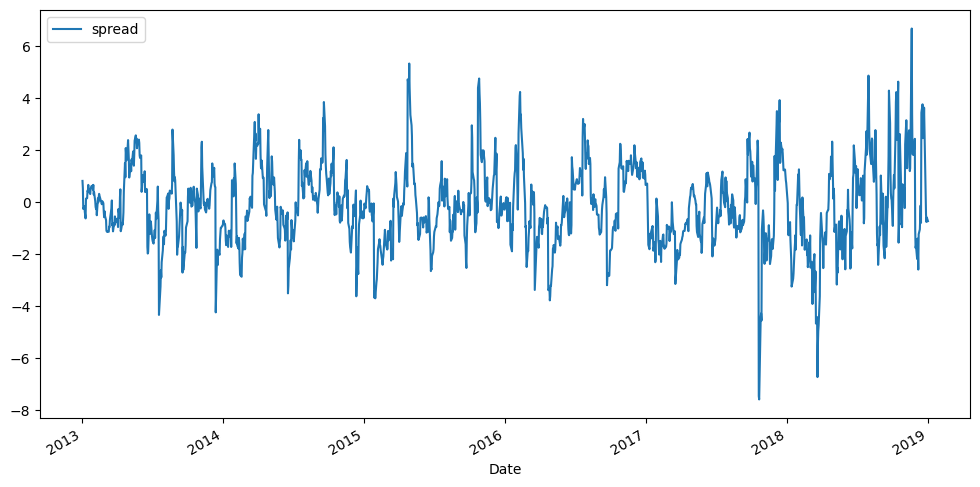

In [ ]:
state_means = KalmanFilterRegression(KalmanFilterAverage(df['ADBE']),KalmanFilterAverage(df['MSFT']))  # Get the output

df['beta'] = state_means[:, 0]  # First column is beta
df['alpha'] = state_means[:, 1]   # Second column is alpha

df['spread'] = df['MSFT'] -df['alpha']  - df['beta'] * df['ADBE']

df['spread'].plot(figsize=(12,6))
plt.legend()
plt.show()

In [ ]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]

    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]

    spread_lag2 = sm.add_constant(spread_lag)

    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [ ]:
halflife = half_life(df['spread'])
halflife

5

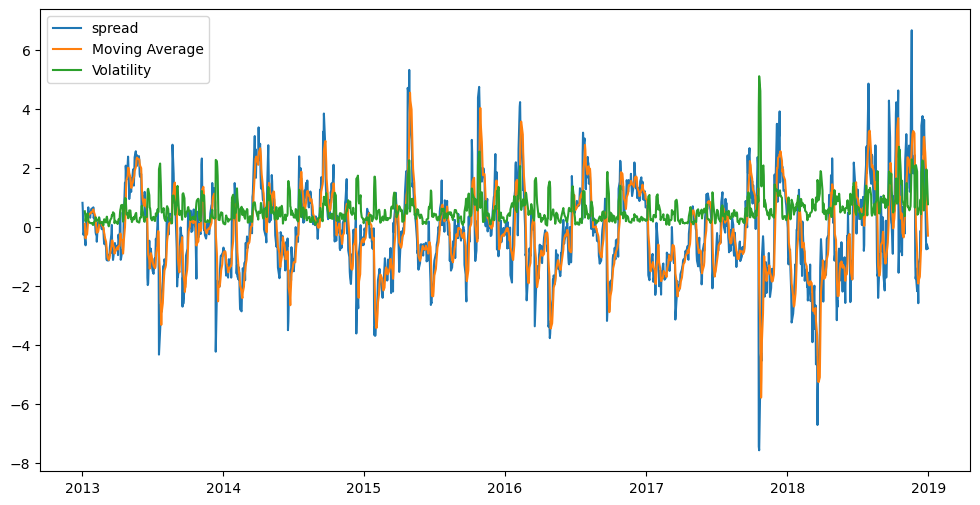

In [ ]:
meanSpread = df.spread.rolling(window=halflife).mean()
stdSpread = df.spread.rolling(window=halflife).std()

plt.figure(figsize=(12,6))
plt.plot(df.index,df['spread'],label='spread')
plt.plot(df.index,meanSpread,label='Moving Average')
plt.plot(df.index,stdSpread,label='Volatility')
plt.legend()


plt.show()

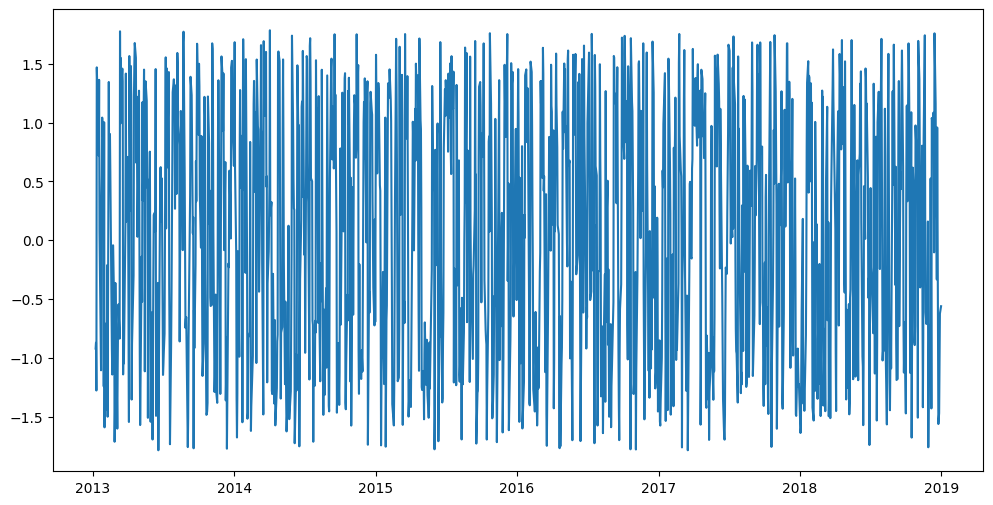

In [ ]:
df['zScore'] = (df.spread-meanSpread)/stdSpread
plt.figure(figsize=(12,6))
plt.plot(df['zScore'])

In [ ]:
entryZscore = 1.5
exitZscore = 0

df['long entry'] = ((df.zScore < - entryZscore) & ( df.zScore.shift(1) > - entryZscore))
df['long exit'] = ((df.zScore > - exitZscore) & (df.zScore.shift(1) < - exitZscore))
df['num units long'] = np.nan
df.loc[df['long entry'],'num units long'] = 1
df.loc[df['long exit'],'num units long'] = 0
df['num units long'][0] = 0
df['num units long'] = df['num units long'].fillna(method='pad')

# Set up num units short
df['short entry'] = ((df.zScore >  entryZscore) & ( df.zScore.shift(1) < entryZscore))
df['short exit'] = ((df.zScore < exitZscore) & (df.zScore.shift(1) > exitZscore))
df.loc[df['short entry'],'num units short'] = -1
df.loc[df['short exit'],'num units short'] = 0
df['num units short'][0] = 0
df['num units short'] = df['num units short'].fillna(method='pad')

df['numUnits'] = df['num units long'] + df['num units short']
df['spread pct ch'] = (df['spread'] - df['spread'].shift(1)) / ((df['ADBE'] * abs(df['beta'])) + df['MSFT'])
df['port rets'] = df['spread pct ch'] * df['numUnits'].shift(1)

df['cum rets'] = df['port rets'].cumsum()
df['cum rets'] = df['cum rets'] + 1

try:
    sharpe = ((df['port rets'].mean() / df['port rets'].std()) * sqrt(252))
except ZeroDivisionError:
    sharpe = 0.0

sharpe

1.2634426824086427

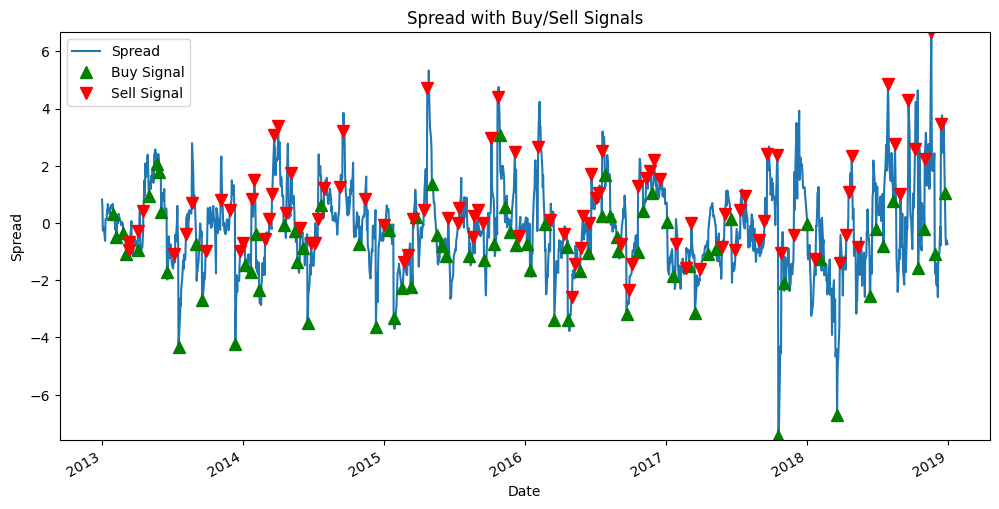

In [ ]:
# Create buy and sell signals
buy_signals = df['spread'].copy()
sell_signals = df['spread'].copy()

# Apply the buy/sell conditions
buy_signals[~df['long entry']] = np.nan  # Only keep buy signals
sell_signals[~df['short entry']] = np.nan  # Only keep sell signals

# Plot spread and signals
plt.figure(figsize=(12, 6))

# Plot the spread
df['spread'].plot(label='Spread')

# Plot buy signals
plt.plot(buy_signals, color='green', linestyle='None', marker='^', label='Buy Signal', markersize=8)

# Plot sell signals
plt.plot(sell_signals, color='red', linestyle='None', marker='v', label='Sell Signal', markersize=8)

# Add labels, legend, and limits
plt.title('Spread with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.ylim(df['spread'].min(), df['spread'].max())  # Adjust y-axis range dynamically

# Show the plot
plt.show()

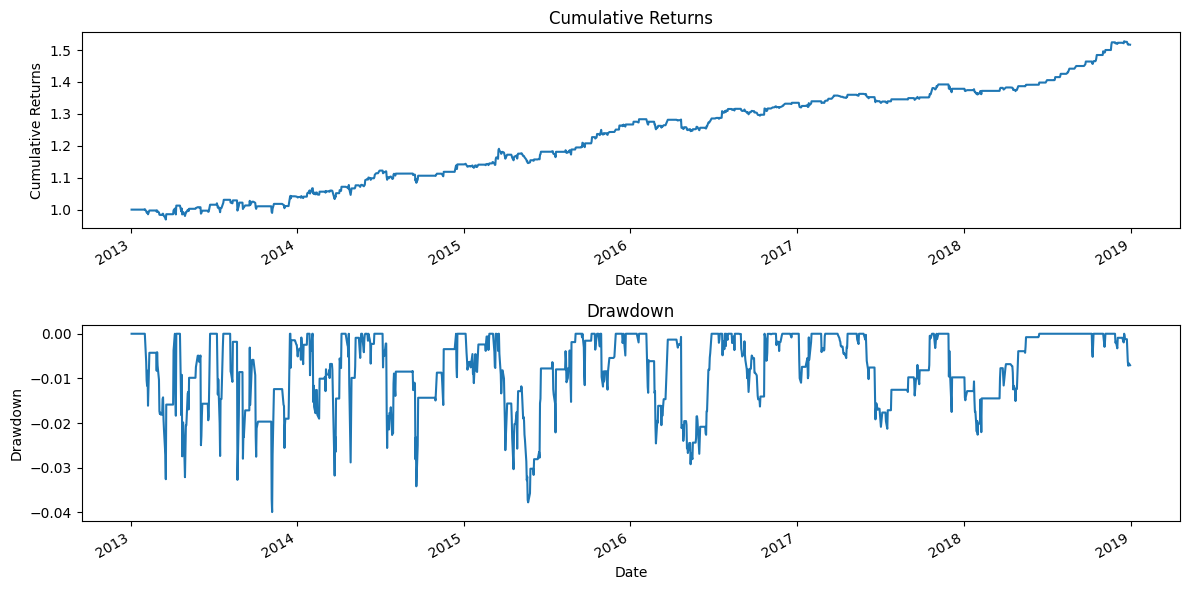

In [ ]:
# Compute the drawdown series for cumulative returns
drawdowns = df['cum rets'].to_drawdown_series()

# Add drawdown to your DataFrame
df['drawdown'] = drawdowns

plt.figure(figsize=(12, 6))

# Cumulative returns
plt.subplot(2, 1, 1)
df['cum rets'].plot(title='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# Drawdown
plt.subplot(2, 1, 2)
df['drawdown'].plot(title='Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')

plt.tight_layout()
plt.show()

In [ ]:
print(df['cum rets'])

Date
2013-01-02         NaN
2013-01-03    1.000000
2013-01-04    1.000000
2013-01-07    1.000000
2013-01-08    1.000000
                ...   
2018-12-24    1.525816
2018-12-26    1.518169
2018-12-27    1.516744
2018-12-28    1.517611
2018-12-31    1.516910
Name: cum rets, Length: 1510, dtype: float64


In [ ]:
print(df['drawdown'].min())

-0.039924688153807564
